In [1]:
import numpy as np
from scipy.io import loadmat
import scipy.stats

# 归一化数据
def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pc_number(X):
    U, S, V = np.linalg.svd(X)
    if S.shape[0] == 1:
        i = 1
    else:
        i = 0
        var = 0
        while var < 0.85*sum(S*S):
            var = var+S[i]*S[i]
            i = i + 1
    return i

def DiCCA(X, s, a):
    n = X.shape[0]
    m = X.shape[1]
    N = n - s
    alpha = 0.01
    level = 1-alpha
    P = np.zeros((m, a))
    W = np.zeros((m, a))
    T = np.zeros((n, a))
    Beta = np.zeros((s, a))
    w = np.zeros(m)
    w[0]=1
    Xe = X[s:N+s, :]
    if s > 0:
        l = 0
        while l < a:
            iterr = 1000
            temp = np.dot(X, w)
            temp = temp / np.linalg.norm(temp, ord=2)
            while iterr > 0.00001:
                t = np.dot(X, w)
#                 print(t.shape)
                t = t / np.linalg.norm(t, ord=2)
                Ts = np.zeros((N, s));
#                 t = np.array([t]).T
                for i in range(s):
                    Ts[:,i]= t[i:(N+i)]
#                 t = np.array([t]).T 
#                 print(np.dot(Ts.T,t[s:(N+s)]))
#                 print((Ts.T)@t[s:(N+s)])
                beta = np.linalg.pinv((Ts.T@Ts))@np.dot(Ts.T,t[s:(N+s)]);
#                 print((Ts.T@Ts)*np.linalg.inv(Ts.T@t[s:(N+s),:]))
                X_hat = np.zeros([N,m]);
                t_hat = np.zeros([N]);
#                 T_hat = np.zeros([N,l]);
#                 print(beta)
                for i in range(s):
                    X_hat= X_hat + beta[i]*X[s-i-1:(N+s-i-1), :]
                for i in range(s):
                    t_hat= t_hat + beta[i]*t[s-i-1:(N+s-i-1)]
#                 print((Xe.T@Xe+X_hat.T@X_hat).shape,(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s]))).shape)
                w = np.linalg.pinv(Xe.T@Xe+X_hat.T@X_hat, rcond=1e-9)@(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s])))
#                 print(w)
                t = np.dot(X, w)
                t = t / np.linalg.norm(t, ord=2)
                iterr = np.linalg.norm((t-temp), ord=2)
#                 print(iterr)
                temp = t
            p= np.dot(X.T, t)/np.dot(t.T, t)
#             print(t)
#             print(t.shape,p.shape)
            t = np.array([t]).T
            p = np.array([p]).T
            
            X = X - np.dot(t, p.T)
            t = t* np.linalg.norm(p, ord=2)
            w = w* np.linalg.norm(p, ord=2)   
            p = p/ np.linalg.norm(p, ord=2)
            t_hat=t_hat / np.linalg.norm(t_hat, ord=2)
           
            P[:, l] = p[:, 0]
            W[:, l] = w
            T[:, l] = t[:, 0]
            Beta[:, l]=beta
            l = l+1
      
        # Dynamic Inner Modeling
        V = T[s:(N+s), :]    
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
                
#             print(Xe.shape,TTs.shape,Beta[:,i].shape,(P[:,i].reshape(1,P.shape[0])).shape,(TTs@Beta[:,i]).shape)
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
            V[:,i]=V[:,i]-TTs@Beta[:,i]
        av = pc_number(V)
        _, Sv, Pv = np.linalg.svd(V)
        Pv = Pv.T
        Pv = Pv[:, 0:av]
        lambda_v = 1/(N-1)*np.diag(Sv[0:av]**2)
        if av!=a:
            gv = 1/(N-1)*sum(Sv[av:a]**4)/sum(Sv[av:a]**2)
            hv = (sum(Sv[av:a]**2)**2)/sum(Sv[av:a]**4)
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av) 
            Qv_lim = gv*scipy.stats.chi2.ppf(level, hv) 
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)/Tv2_lim + (np.identity(len(Pv@Pv.T))-Pv@Pv.T)/Qv_lim;
            SS_v=1/(N-1)*V.T@V
            g_phi_v=np.trace((SS_v@PHI_v)@(SS_v@PHI_v))/(np.trace(SS_v@PHI_v))
            h_phi_v=(np.trace(SS_v@SS_v)**2)/np.trace((SS_v@PHI_v)@(SS_v@PHI_v))
            phi_v_lim = g_phi_v*scipy.stats.chi2.ppf(level, h_phi_v)
        else:
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av)
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)
            phi_v_lim=Tv2_lim
        
    a_s = pc_number(Xe)
    _, Ss, Ps = np.linalg.svd(Xe)
    Ps = Ps.T
    Ps = Ps[:,0:a_s]
    Ts = np.dot(Xe, Ps)
    lambda_s = 1 / (N - 1) * np.diag(Ss[0:a_s] ** 2)
    m = Ss.shape[0]
    gs = 1 / (N - 1) * sum(Ss[a_s:m] ** 4) / sum(Ss[a_s:m] ** 2)
    hs = (sum(Ss[a_s:m] ** 2) ** 2) / sum(Ss[a_s:m] ** 4)
    Ts2_lim = a_s * (N ** 2 - 1) / (N * (N - a_s))* scipy.stats.f.ppf(level, a_s, N-a_s) 

    Qs_lim = gs*scipy.stats.chi2.ppf(level, hs) 
    PHI_s = Ps@np.linalg.pinv(lambda_s)@Ps.T/Ts2_lim + (np.identity(len(Ps@Ps.T))-Ps@Ps.T)/Qs_lim;

    SS_s=1/(N-1)*Xe.T@Xe
    g_phi_s=np.trace((SS_s@PHI_s)@(SS_s@PHI_s))/(np.trace(SS_s@PHI_s))

    h_phi_s=(np.trace(SS_s@PHI_s)**2)/np.trace((SS_s@PHI_s)@(SS_s@PHI_s))

    phi_s_lim = g_phi_s*scipy.stats.chi2.ppf(level, h_phi_s) 
    return P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim,PHI_v


def DiCCA_test(X,P,W,Theta,Ps,s,lambda_s,PHI_v):
    n = X.shape[0]
    N = n - s
    a = P.shape[1]
    Mst = np.dot(np.dot(Ps, np.linalg.inv(lambda_s)), Ps.T)
    Msq = np.eye((Mst.shape[0])) - np.dot(Ps, Ps.T)
    R = np.dot(W, np.linalg.inv(np.dot(P.T, W)))
    if s > 0:
        T = np.dot(X, R)
        TTs = np.zeros((N, s))
        Xe=X[s:(N+s),:]
        V=T[s:(N+s),:]
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
            V[:,i]=V[:,i]-TTs@Beta[:,i]
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
    phi_v_index = np.zeros(N)
    Ts_index = np.zeros(N)
    Qs_index = np.zeros(N)
    k = s
    while k < s+N:
        if s > 0:
            temp = V[k-s, :] 
            temp = np.array([temp])
            v = temp.T
            phi_v_index[k-s] = np.dot(np.dot(v.T, PHI_v), v)
            e = Xe[k-s, :].T 
        else:
            e = Xe[k-s, :].T
        Ts_index[k-s] = np.dot(np.dot(e.T, Mst), e)
        Qs_index[k-s] = np.dot(np.dot(e.T, Msq), e)
        k = k+1

    return phi_v_index,Ts_index,Qs_index
x_train= loadmat("E:/myFile/Tencent Files/故障诊断/d00.mat")['d00']
x_test = loadmat("E:/myFile/Tencent Files/故障诊断/d05te.mat")['d05te']
a = 5
s = 1
X,X_mean,X_s = autos(x_train)
x_test = autos_test(x_test,X_mean,X_s)
P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim, PHI_v= DiCCA(X, s, a);
phi_v_index,Ts_index,Qs_index = DiCCA_test(x_test, P, W, Beta, Ps, s, lambda_s, PHI_v);
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(3,1,1)
plt.plot(phi_v_index)
plt.plot(phi_v_lim*np.ones(len(phi_v_index)),'r--')
plt.subplot(3,1,2)
plt.plot(Ts_index)
plt.plot(Ts2_lim*np.ones(len(phi_v_index)),'r--')

plt.subplot(3,1,3)
plt.plot(Qs_index)
plt.plot(Qs_lim*np.ones(len(phi_v_index)),'r--')


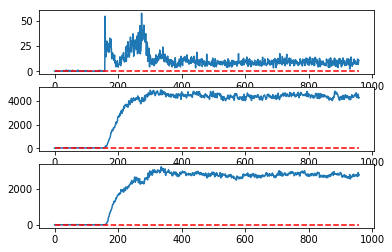

In [16]:
import numpy as np
from scipy.io import loadmat
import scipy.stats

# 归一化数据
def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pc_number(X):
    U, S, V = np.linalg.svd(X)
    if S.shape[0] == 1:
        i = 1
    else:
        i = 0
        var = 0
        while var < 0.85*sum(S*S):
            var = var+S[i]*S[i]
            i = i + 1
    return i

def DiCCA(X, s, a):
    n = X.shape[0]
    m = X.shape[1]
    N = n - s
    alpha = 0.01
    level = 1-alpha
    P = np.zeros((m, a))
    W = np.zeros((m, a))
    T = np.zeros((n, a))
    Beta = np.zeros((s, a))
    w = np.zeros(m)
    w[0]=1
    Xe = X[s:N+s, :]
    if s > 0:
        l = 0
        while l < a:
            iterr = 1000
            temp = np.dot(X, w)
            temp = temp / np.linalg.norm(temp, ord=2)
            while iterr > 0.00001:
                t = np.dot(X, w)
#                 print(t.shape)
                t = t / np.linalg.norm(t, ord=2)
                Ts = np.zeros((N, s));
#                 t = np.array([t]).T
                for i in range(s):
                    Ts[:,i]= t[i:(N+i)]
#                 t = np.array([t]).T 
#                 print(np.dot(Ts.T,t[s:(N+s)]))
#                 print((Ts.T)@t[s:(N+s)])
                beta = np.linalg.pinv((Ts.T@Ts))@np.dot(Ts.T,t[s:(N+s)]);
#                 print((Ts.T@Ts)*np.linalg.inv(Ts.T@t[s:(N+s),:]))
                X_hat = np.zeros([N,m]);
                t_hat = np.zeros([N]);
#                 T_hat = np.zeros([N,l]);
#                 print(beta)
                for i in range(s):
                    X_hat= X_hat + beta[i]*X[s-i-1:(N+s-i-1), :]
                for i in range(s):
                    t_hat= t_hat + beta[i]*t[s-i-1:(N+s-i-1)]
#                 print((Xe.T@Xe+X_hat.T@X_hat).shape,(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s]))).shape)
                w = np.linalg.pinv(Xe.T@Xe+X_hat.T@X_hat, rcond=1e-9)@(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s])))
#                 print(w)
                t = np.dot(X, w)
                t = t / np.linalg.norm(t, ord=2)
                iterr = np.linalg.norm((t-temp), ord=2)
#                 print(iterr)
                temp = t
            p= np.dot(X.T, t)/np.dot(t.T, t)
#             print(t)
#             print(t.shape,p.shape)
            t = np.array([t]).T
            p = np.array([p]).T
            
            X = X - np.dot(t, p.T)
            t = t* np.linalg.norm(p, ord=2)
            w = w* np.linalg.norm(p, ord=2)   
            p = p/ np.linalg.norm(p, ord=2)
            t_hat=t_hat / np.linalg.norm(t_hat, ord=2)
           
            P[:, l] = p[:, 0]
            W[:, l] = w
            T[:, l] = t[:, 0]
            Beta[:, l]=beta
            l = l+1
      
        # Dynamic Inner Modeling
        V = T[s:(N+s), :]    
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
                
#             print(Xe.shape,TTs.shape,Beta[:,i].shape,(P[:,i].reshape(1,P.shape[0])).shape,(TTs@Beta[:,i]).shape)
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
            V[:,i]=V[:,i]-TTs@Beta[:,i]
        av = pc_number(V)
        _, Sv, Pv = np.linalg.svd(V)
        Pv = Pv.T
        Pv = Pv[:, 0:av]
        lambda_v = 1/(N-1)*np.diag(Sv[0:av]**2)
        if av!=a:
            gv = 1/(N-1)*sum(Sv[av:a]**4)/sum(Sv[av:a]**2)
            hv = (sum(Sv[av:a]**2)**2)/sum(Sv[av:a]**4)
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av) 
            Qv_lim = gv*scipy.stats.chi2.ppf(level, hv) 
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)/Tv2_lim + (np.identity(len(Pv@Pv.T))-Pv@Pv.T)/Qv_lim;
            SS_v=1/(N-1)*V.T@V
            g_phi_v=np.trace((SS_v@PHI_v)@(SS_v@PHI_v))/(np.trace(SS_v@PHI_v))
            h_phi_v=(np.trace(SS_v@SS_v)**2)/np.trace((SS_v@PHI_v)@(SS_v@PHI_v))
            phi_v_lim = g_phi_v*scipy.stats.chi2.ppf(level, h_phi_v)
        else:
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av)
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)
            phi_v_lim=Tv2_lim
        
    a_s = pc_number(Xe)
    _, Ss, Ps = np.linalg.svd(Xe)
    Ps = Ps.T
    Ps = Ps[:,0:a_s]
    Ts = np.dot(Xe, Ps)
    lambda_s = 1 / (N - 1) * np.diag(Ss[0:a_s] ** 2)
    m = Ss.shape[0]
    gs = 1 / (N - 1) * sum(Ss[a_s:m] ** 4) / sum(Ss[a_s:m] ** 2)
    hs = (sum(Ss[a_s:m] ** 2) ** 2) / sum(Ss[a_s:m] ** 4)
    Ts2_lim = a_s * (N ** 2 - 1) / (N * (N - a_s))* scipy.stats.f.ppf(level, a_s, N-a_s) 

    Qs_lim = gs*scipy.stats.chi2.ppf(level, hs) 
    PHI_s = Ps@np.linalg.pinv(lambda_s)@Ps.T/Ts2_lim + (np.identity(len(Ps@Ps.T))-Ps@Ps.T)/Qs_lim;

    SS_s=1/(N-1)*Xe.T@Xe
    g_phi_s=np.trace((SS_s@PHI_s)@(SS_s@PHI_s))/(np.trace(SS_s@PHI_s))

    h_phi_s=(np.trace(SS_s@PHI_s)**2)/np.trace((SS_s@PHI_s)@(SS_s@PHI_s))

    phi_s_lim = g_phi_s*scipy.stats.chi2.ppf(level, h_phi_s) 
    return P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim,PHI_v


def DiCCA_test(X,P,W,Theta,Ps,s,lambda_s,PHI_v):
    n = X.shape[0]
    N = n - s
    a = P.shape[1]
    Mst = np.dot(np.dot(Ps, np.linalg.inv(lambda_s)), Ps.T)
    Msq = np.eye((Mst.shape[0])) - np.dot(Ps, Ps.T)
    R = np.dot(W, np.linalg.inv(np.dot(P.T, W)))
    if s > 0:
        T = np.dot(X, R)
        TTs = np.zeros((N, s))
        Xe=X[s:(N+s),:]
        V=T[s:(N+s),:]
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
            V[:,i]=V[:,i]-TTs@Beta[:,i]
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
    phi_v_index = np.zeros(N)
    Ts_index = np.zeros(N)
    Qs_index = np.zeros(N)
    k = s
    while k < s+N:
        if s > 0:
            temp = V[k-s, :] 
            temp = np.array([temp])
            v = temp.T
            phi_v_index[k-s] = np.dot(np.dot(v.T, PHI_v), v)
            e = Xe[k-s, :].T 
        else:
            e = Xe[k-s, :].T
        Ts_index[k-s] = np.dot(np.dot(e.T, Mst), e)
        Qs_index[k-s] = np.dot(np.dot(e.T, Msq), e)
        k = k+1

    return phi_v_index,Ts_index,Qs_index
x_train= loadmat("E:/myFile/Tencent Files/故障诊断/d00.mat")['d00']
x_test = loadmat("E:/myFile/Tencent Files/故障诊断/d05te.mat")['d05te']
a = 3
s = 1
X,X_mean,X_s = autos(x_train)
x_test = autos_test(x_test,X_mean,X_s)
P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim, PHI_v= DiCCA(X, s, a);
phi_v_index,Ts_index,Qs_index = DiCCA_test(x_test, P, W, Beta, Ps, s, lambda_s, PHI_v);
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(3,1,1)
plt.plot(phi_v_index)
plt.plot(phi_v_lim*np.ones(len(phi_v_index)),'r--')
plt.subplot(3,1,2)
plt.plot(Ts_index)
plt.plot(Ts2_lim*np.ones(len(phi_v_index)),'r--')

plt.subplot(3,1,3)
plt.plot(Qs_index)
plt.plot(Qs_lim*np.ones(len(phi_v_index)),'r--')


2 1


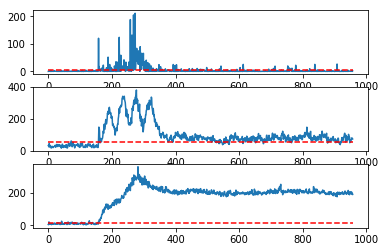

In [22]:
import numpy as np
from scipy.io import loadmat
import scipy.stats

# 归一化数据
def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pc_number(X):
    U, S, V = np.linalg.svd(X)
    if S.shape[0] == 1:
        i = 1
    else:
        i = 0
        var = 0
        while var < 0.85*sum(S*S):
            var = var+S[i]*S[i]
            i = i + 1
    return i

def DiCCA(X, s, a):
    n = X.shape[0]
    m = X.shape[1]
    N = n - s
    alpha = 0.01
    level = 1-alpha
    P = np.zeros((m, a))
    W = np.zeros((m, a))
    T = np.zeros((n, a))
    Beta = np.zeros((s, a))
    w = np.zeros(m)
    w[0]=1
    Xe = X[s:N+s, :]
    if s > 0:
        l = 0
        while l < a:
            iterr = 1000
            temp = np.dot(X, w)
            temp = temp / np.linalg.norm(temp, ord=2)
            while iterr > 0.00001:
                t = np.dot(X, w)
#                 print(t.shape)
                t = t / np.linalg.norm(t, ord=2)
                Ts = np.zeros((N, s));
#                 t = np.array([t]).T
                for i in range(s):
                    Ts[:,i]= t[i:(N+i)]
#                 t = np.array([t]).T 
#                 print(np.dot(Ts.T,t[s:(N+s)]))
#                 print((Ts.T)@t[s:(N+s)])
                beta = np.linalg.pinv((Ts.T@Ts))@np.dot(Ts.T,t[s:(N+s)]);
#                 print((Ts.T@Ts)*np.linalg.inv(Ts.T@t[s:(N+s),:]))
                X_hat = np.zeros([N,m]);
                t_hat = np.zeros([N]);
#                 T_hat = np.zeros([N,l]);
#                 print(beta)
                for i in range(s):
                    X_hat= X_hat + beta[i]*X[s-i-1:(N+s-i-1), :]
                for i in range(s):
                    t_hat= t_hat + beta[i]*t[s-i-1:(N+s-i-1)]
#                 print((Xe.T@Xe+X_hat.T@X_hat).shape,(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s]))).shape)
                w = np.linalg.pinv(Xe.T@Xe+X_hat.T@X_hat, rcond=1e-9)@(np.dot(Xe.T,t_hat)+(np.dot(X_hat.T,t[s:N+s])))
#                 print(w)
                t = np.dot(X, w)
                t = t / np.linalg.norm(t, ord=2)
                iterr = np.linalg.norm((t-temp), ord=2)
#                 print(iterr)
                temp = t
            p= np.dot(X.T, t)/np.dot(t.T, t)
#             print(t)
#             print(t.shape,p.shape)
            t = np.array([t]).T
            p = np.array([p]).T
            
            X = X - np.dot(t, p.T)
            t = t* np.linalg.norm(p, ord=2)
            w = w* np.linalg.norm(p, ord=2)   
            p = p/ np.linalg.norm(p, ord=2)
            t_hat=t_hat / np.linalg.norm(t_hat, ord=2)
           
            P[:, l] = p[:, 0]
            W[:, l] = w
            T[:, l] = t[:, 0]
            Beta[:, l]=beta
            l = l+1
      
        # Dynamic Inner Modeling
        V = T[s:(N+s), :]    
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
                
#             print(Xe.shape,TTs.shape,Beta[:,i].shape,(P[:,i].reshape(1,P.shape[0])).shape,(TTs@Beta[:,i]).shape)
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
            V[:,i]=V[:,i]-TTs@Beta[:,i]
        av = pc_number(V)
        _, Sv, Pv = np.linalg.svd(V)
        Pv = Pv.T
        Pv = Pv[:, 0:av]
        lambda_v = 1/(N-1)*np.diag(Sv[0:av]**2)
        if av!=a:
            gv = 1/(N-1)*sum(Sv[av:a]**4)/sum(Sv[av:a]**2)
            hv = (sum(Sv[av:a]**2)**2)/sum(Sv[av:a]**4)
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av) 
            Qv_lim = gv*scipy.stats.chi2.ppf(level, hv) 
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)/Tv2_lim + (np.identity(len(Pv@Pv.T))-Pv@Pv.T)/Qv_lim;
            SS_v=1/(N-1)*V.T@V
            g_phi_v=np.trace((SS_v@PHI_v)@(SS_v@PHI_v))/(np.trace(SS_v@PHI_v))
            h_phi_v=(np.trace(SS_v@SS_v)**2)/np.trace((SS_v@PHI_v)@(SS_v@PHI_v))
            phi_v_lim = g_phi_v*scipy.stats.chi2.ppf(level, h_phi_v)
        else:
            Tv2_lim = av * (N ** 2 - 1) / (N * (N - av))* scipy.stats.f.ppf(level, av, N-av)
            PHI_v = np.dot(np.dot(Pv, np.linalg.inv(lambda_v)), Pv.T)
            phi_v_lim=Tv2_lim
        
    a_s = pc_number(Xe)
    _, Ss, Ps = np.linalg.svd(Xe)
    Ps = Ps.T
    Ps = Ps[:,0:a_s]
    Ts = np.dot(Xe, Ps)
    lambda_s = 1 / (N - 1) * np.diag(Ss[0:a_s] ** 2)
    m = Ss.shape[0]
    gs = 1 / (N - 1) * sum(Ss[a_s:m] ** 4) / sum(Ss[a_s:m] ** 2)
    hs = (sum(Ss[a_s:m] ** 2) ** 2) / sum(Ss[a_s:m] ** 4)
    Ts2_lim = a_s * (N ** 2 - 1) / (N * (N - a_s))* scipy.stats.f.ppf(level, a_s, N-a_s) 

    Qs_lim = gs*scipy.stats.chi2.ppf(level, hs) 
    PHI_s = Ps@np.linalg.pinv(lambda_s)@Ps.T/Ts2_lim + (np.identity(len(Ps@Ps.T))-Ps@Ps.T)/Qs_lim;

    SS_s=1/(N-1)*Xe.T@Xe
    g_phi_s=np.trace((SS_s@PHI_s)@(SS_s@PHI_s))/(np.trace(SS_s@PHI_s))

    h_phi_s=(np.trace(SS_s@PHI_s)**2)/np.trace((SS_s@PHI_s)@(SS_s@PHI_s))

    phi_s_lim = g_phi_s*scipy.stats.chi2.ppf(level, h_phi_s) 
    print(s,a)
    return P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim,PHI_v


def DiCCA_test(X,P,W,Theta,Ps,s,lambda_s,PHI_v):
    n = X.shape[0]
    N = n - s
    a = P.shape[1]
    Mst = np.dot(np.dot(Ps, np.linalg.inv(lambda_s)), Ps.T)
    Msq = np.eye((Mst.shape[0])) - np.dot(Ps, Ps.T)
    R = np.dot(W, np.linalg.inv(np.dot(P.T, W)))
    if s > 0:
        T = np.dot(X, R)
        TTs = np.zeros((N, s))
        Xe=X[s:(N+s),:]
        V=T[s:(N+s),:]
        for i in range(a):
            TTs=np.zeros((N, s))
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
            V[:,i]=V[:,i]-TTs@Beta[:,i]
            Xe=Xe-TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
    phi_v_index = np.zeros(N)
    Ts_index = np.zeros(N)
    Qs_index = np.zeros(N)
    k = s
    while k < s+N:
        if s > 0:
            temp = V[k-s, :] 
            temp = np.array([temp])
            v = temp.T
            phi_v_index[k-s] = np.dot(np.dot(v.T, PHI_v), v)
            e = Xe[k-s, :].T 
        else:
            e = Xe[k-s, :].T
        Ts_index[k-s] = np.dot(np.dot(e.T, Mst), e)
        Qs_index[k-s] = np.dot(np.dot(e.T, Msq), e)
        k = k+1

    return phi_v_index,Ts_index,Qs_index
x_train= loadmat("E:/myFile/Tencent Files/故障诊断/d00.mat")['d00']
x_test = loadmat("E:/myFile/Tencent Files/故障诊断/d05te.mat")['d05te']
a = 5
s = 2
X,X_mean,X_s = autos(x_train)
x_test = autos_test(x_test,X_mean,X_s)
P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim, PHI_v= DiCCA(X, s, a);
phi_v_index,Ts_index,Qs_index = DiCCA_test(x_test, P, W, Beta, Ps, s, lambda_s, PHI_v);
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(3,1,1)
plt.plot(phi_v_index)
plt.plot(phi_v_lim*np.ones(len(phi_v_index)),'r--')
plt.subplot(3,1,2)
plt.plot(Ts_index)
plt.plot(Ts2_lim*np.ones(len(phi_v_index)),'r--')

plt.subplot(3,1,3)
plt.plot(Qs_index)
plt.plot(Qs_lim*np.ones(len(phi_v_index)),'r--')


In [19]:
def DiCCA_predict(X_test,P,W,Beta,s):
    R=W@np.linalg.inv(P.T@W)
    [m,n]=X_test.shape
    x_predict_d=np.zeros(X_test.shape, dtype=float)
    T = X_test@R
    N=m-s 
#     print(N)
    a=P.shape[1]
    TT=np.zeros([N,a])
    TT=T[0:N,:]
    for i in range(a):
        Ts=np.zeros([N,s])
        if s>1:
            for j in range(1,s):
                Ts=T[j:(N+j),i]
                TT = np.c_[TT,Ts]
    x_predict_d[s:,:] = TT@Beta@P.T;

    return({'x_predict_d':x_predict_d.tolist()})


In [28]:
def DiCCA_predict(X_test,P,W,Beta,s):
    R=W@np.linalg.inv(P.T@W)
    [m,n]=X_test.shape
    N=m-s 
    a=P.shape[1]
    if s > 0:
        T = np.dot(X_test, R)
        TTs = np.zeros((N, s))
        x_predict_d=np.zeros(X_test.shape, dtype=float)
        for i in range(a):
            for j in range(s):
                TTs[:, j] = T[j:(N+j), i]
#             print(TTs.shape)
            x_predict_d[s:,:]+=TTs@(Beta[:,i].reshape(-1,1))@(P[:,i].reshape(1,P.shape[0]))
            return(x_predict_d)

In [15]:
from  math import floor
fold = 2;  # n fold cross-validation
s=2# lag number range
a=5#  number of latent variables range
(n, m )= X.shape;
n_sub = floor(n/fold);
press=np.zeros((s,a,fold), float) 
for i in range(s):
    for j in range(a):
            print(i,j)
            count=0
            for k in range(fold):
                count+=1
                train_index=list(range(0,n_sub*(fold-k-1)))+list(range(n_sub*(fold-k),n))
                valid_index=list(range(n_sub*(fold-k-1),n_sub*(fold-k)))
#                 print(train_index)
                X_train, X_valid = X[train_index], X[valid_index]               
                P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim, PHI_v= DiCCA(X_train, i+1, j+1);
                X_predict=DiCCA_predict(X_valid,P,W,Beta,i+1)
                press[i][j][count-1]=np.linalg.norm(X_valid-X_predict,ord=2)**2/X_valid.shape[0]
                print(np.linalg.norm(X_valid-X_predict,ord=2)**2/X_valid.shape[0])

0 0
7.4508645762776675
4.278020301015547
0 1
7.450864576277666
4.278020301015552
0 2
7.450864576277666
4.278020301015549
0 3
7.4508645762776675
4.278020301015547
0 4
7.4508645762776675
4.2780203010155455
1 0
7.256792457556835
4.2947513125641406
1 1
7.256792457556835
4.294751312564142
1 2
7.256792457556838
4.294751312564142
1 3
7.256792457556835
4.294751312564144
1 4
7.256792457556838
4.294751312564142


In [14]:
press

array([[[7.45086458, 4.2780203 ],
        [7.45086458, 4.2780203 ],
        [7.45086458, 4.2780203 ],
        [7.45086458, 4.2780203 ],
        [7.45086458, 4.2780203 ]],

       [[7.25679246, 4.29475131],
        [7.25679246, 4.29475131],
        [7.25679246, 4.29475131],
        [7.25679246, 4.29475131],
        [7.25679246, 4.29475131]]])

In [32]:
P,W,Beta,Ps,lambda_s,Ts2_lim,Qs_lim,phi_v_lim, PHI_v= DiCCA(X, 2, 2);

x_predict_d=DiCCA_predict(X,P,W,Beta,2)
np.linalg.norm(x_predict_d)

2 2


47.04821245778391

In [34]:
x_predict_d[100]

array([ 0.05543641, -0.00669007, -0.13755534,  0.05143535, -0.02884681,
       -0.02175074, -0.4945885 , -0.13419578,  0.00949337,  0.31624924,
        0.32911638, -0.04606844, -0.47072628,  0.02548943,  0.04375536,
       -0.56348729, -0.00334652,  1.08994664,  1.09898115,  0.04766717,
       -0.05797003,  0.17075641,  0.13942089,  0.19993549, -0.33242857,
       -0.04315316,  0.16131368,  0.19699825,  0.18453162,  0.3143523 ,
       -0.45132778,  0.02274872,  0.08469703,  0.21292901,  0.12099166,
        0.15604821, -0.14880891, -0.21693353,  0.04136093,  0.12019974,
       -0.0601701 ,  0.00304959, -0.23324041,  0.05678903,  0.0563608 ,
       -0.12640724,  0.30627092, -0.04606745,  0.043753  ,  1.11415806,
        0.02212114,  0.00184553])

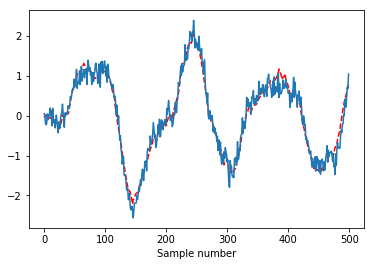

In [113]:
x_predict_d=DiCCA_predict(X,P,W,Beta,s)
plt.figure()
plt.plot(x_predict_d[:,18],'r--')
plt.plot(X[:,18])

plt.xlabel('Sample number')
#plt.ylim((0,400))
plt.show()

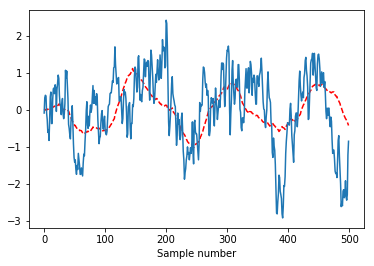

In [114]:
x_predict_d=DiCCA_predict(X,P,W,Beta,s)
plt.figure()
plt.plot(x_predict_d[:,15],'r--')
plt.plot(X[:,15])

plt.xlabel('Sample number')
#plt.ylim((0,400))
plt.show()

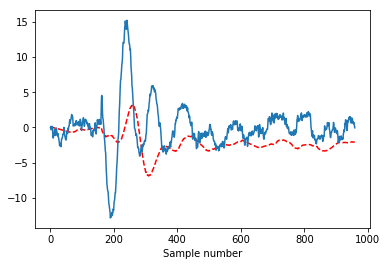

In [109]:
x_predict_d=DiCCA_predict(x_test,P,W,Beta,s)
plt.figure()
plt.plot(x_predict_d[:,12],'r--')
plt.plot(x_test[:,12])

plt.xlabel('Sample number')
#plt.ylim((0,400))
plt.show()

In [29]:
R=W@np.linalg.inv(P.T@W)
[m,n]=x_test.shape
x_predict_d=np.zeros(x_test.shape, dtype=float)
T = x_test@R
N=m-s 
#     print(N)
a=P.shape[1]
# TT=np.zeros([N,a])
TT=T[0:N,:]
for i in range(a):
    Ts=np.zeros([N,s])
#       Ts=np.zeros(X_test.shape, dtype=float)  
    for j in range(1,s):
        Ts=T[j:(N+j),i]
    TT = np.c_[TT,Ts]

In [74]:
R=W@np.linalg.inv(P.T@W)
[m,n]=x_test.shape
x_predict_d=np.zeros(x_test.shape, dtype=float)
T = x_test@R
N=m-s 
#     print(N)
a=P.shape[1]
TT=np.zeros([N,a])
TT=T[0:N,:]
for i in range(a):
    Ts=np.zeros([N,s])
#       Ts=np.zeros(X_test.shape, dtype=float) 
    if s>1:
        for j in range(1,s):
            Ts=T[j:(N+j),i]
            TT = np.c_[TT,Ts]
x_predict_d[s:,:] = np.multiply(TT,Beta).sum(axis=0)@P.T;
#     for i in range(s+1, m):
#         y_predict[i]=(np.multiply(Theta,T[i:i-s-1:-1])).sum(axis=0)@P.T
#     y_predict[s]=(np.multiply(Theta,t[s::-1])).sum(axis=0)@P.T


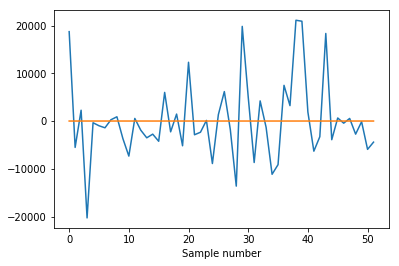

In [75]:
plt.figure()
plt.plot(x_predict_d[1])
plt.plot(x_test[1])
plt.xlabel('Sample number')
#plt.ylim((0,400))
plt.show()

In [66]:
P

array([[ 2.09267978e-02, -4.71402413e-02, -2.82668107e-01,
         9.98204851e-03,  4.04372260e-02],
       [-4.35929637e-03,  1.64505317e-02,  8.21054592e-02,
        -1.70624990e-02, -2.32702409e-02],
       [-5.70083151e-02,  6.41418549e-02, -7.27726992e-02,
        -7.23864248e-03, -3.05352159e-02],
       [ 2.52129587e-02,  1.12532423e-01,  1.85046110e-01,
         3.98677716e-02,  1.00826603e-01],
       [-1.17428173e-02,  4.58399786e-03, -1.15683963e-02,
         3.68319556e-02,  4.39240256e-02],
       [-7.87168048e-03, -1.94077204e-02,  2.19627555e-02,
         8.31850245e-02,  7.37190257e-02],
       [-2.03981439e-01,  3.75484353e-01, -2.34012800e-01,
         6.79476357e-02, -1.72660515e-02],
       [-5.64866855e-02, -5.58096353e-03,  6.83743352e-03,
        -8.92865673e-03, -2.67995591e-02],
       [ 2.33018151e-03,  9.60103347e-03, -5.90707174e-02,
        -1.85774614e-02,  3.39210512e-02],
       [ 1.32737097e-01, -5.09870728e-02,  2.62456820e-01,
         5.81278878e-02

In [63]:
def DiPLS_predict(X_test,P,W,Alpha,Q,s):
    R=W@np.linalg.inv(P.T@W)
    t = X_test@R
    y_predict=np.zeros([X_test.shape[0],1])
    for i in range(s+1, X_test.shape[0]):
        y_predict[i]=(np.multiply(Alpha,t[i:i-s-1:-1])).sum(axis=0)@Q.T
    y_predict[s]=(np.multiply(Alpha,t[s::-1])).sum(axis=0)@Q.T
    return({'y_predict':y_predict.tolist()})

array([[ 1.74058874e-02, -1.15002749e-01,  5.89149675e-02,
         4.17660758e-02, -1.72168081e-01],
       [-1.29960551e-02,  3.37489552e-02,  2.45536885e-01,
        -2.16042565e-03,  1.22403311e-01],
       [-7.10500759e-03, -2.95206789e-01,  3.99939363e-02,
        -9.80181844e-02,  3.99323932e-01],
       ...,
       [ 1.07133841e+01, -6.07497443e+01, -8.34404405e+01,
         5.46850053e+01, -7.20415186e+01],
       [ 1.07169929e+01, -6.08185526e+01, -8.33407767e+01,
         5.48178182e+01, -7.25892287e+01],
       [ 1.07102598e+01, -6.14429808e+01, -8.34241931e+01,
         5.52116747e+01, -7.15387426e+01]])